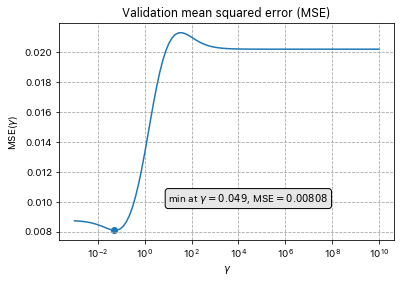

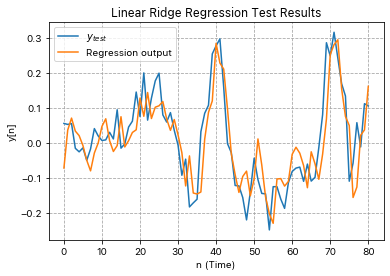

In [1]:
import numpy as np
from numpy.linalg import inv

class RidgeReg:
	def __init__(self, gamma):
		self.gamma_ = gamma

	def fit(self, X, y):
		# append 1 to end of each row for bias
		X = np.append(X,np.ones((len(X),1)),axis=1)
		# calculate the K (kernel) matrix
		K = np.matmul(X.T,X)
		p = np.matmul(X.T,y)
		# calculate the weights
		self.w_ = np.matmul(inv(K+self.gamma_*np.eye(len(K))), p)
		return self

	def predict(self, X):
		X = np.append(X,np.ones((len(X),1)),axis=1)
		y_pred = np.matmul(self.w_.T,X.T)
		return y_pred

	def score(self, X, y):
		ypred = self.predict(X)
		e = y - ypred
		# return negative error so it works with grid search
		return -np.dot(e,e)/len(y)
	
	def set_params(self, **params):
		self.gamma_ = params["gamma"]
		return self
	
	def get_params(self,deep=False):
		return {"gamma":self.gamma_}

import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import matplotlib.font_manager as font_manager
import matplotlib as mpl

# Add every font at the specified location
font_dir = ['/Library/Fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
mpl.rcParams['font.family'] = 'SF Pro Text'



# read the data file
df = pd.read_csv("data.csv", header=None)

#
# break the data file up into components as numpy arrays
#
#ftest = df.iloc[:,0].to_numpy()
#ftrain = df.iloc[:,1].to_numpy()
Xtest = df.iloc[:,2:21].to_numpy()
Xtrain = df.iloc[:,21:40].to_numpy()
ytest = df.iloc[:,40].to_numpy()
ytrain = df.iloc[:,41].to_numpy()

# vary gamma from 10^-2 to 10^1
gammas=10**np.linspace(-3,10,101)

# use grid search to find best gamma
param_grid = {'gamma': gammas}
clf = GridSearchCV(RidgeReg(gamma='auto'), param_grid, cv=5)
clf = clf.fit(Xtrain, ytrain)

# get the scores and find the gamma with smallest error
scores = -clf.cv_results_['mean_test_score'];
be2 = np.inf
sindex = 0
for i in range(len(scores)):
	if scores[i] < be2:
		be2 = scores[i]
		sindex = i
bgamma=gammas[sindex]

# now test it against the full test set
yhat = clf.predict(Xtest)
e2 = -clf.score(Xtest, ytest)

# plot the gamma search
plt.plot(gammas,scores,label="Error")
plt.scatter([bgamma],[be2])
plt.xlabel("$\gamma$")
plt.ylabel("MSE($\gamma$)")
plt.xscale(value="log")
plt.grid(True, which='both', color='0.65', linestyle='--')
plt.annotate("min at $\gamma=%.3f$, MSE$=%.3g$"%(bgamma,be2),xy=(10,0.01), bbox=dict(boxstyle ="round", fc ="0.9"))
plt.title("Validation mean squared error (MSE)")
# plt.title("min at $\gamma=%.3f$, MSE$=%.3g$"%(bgamma,be2),fontsize=10)
plt.show()

# plot real vs. predicted
time = list(range(0,len(yhat)))
plt.plot(time,ytest,label="$y_{test}$")
plt.plot(time,yhat,label="Regression output")
plt.xlabel("n (Time)")
plt.ylabel("y[n]")
plt.grid(True, which='both', color='0.65', linestyle='--')
plt.legend()
plt.title("Linear Ridge Regression Test Results")  # Real vs. Predicted
# plt.title("$\gamma=%.3f$,MSE$=%.3g$"%(bgamma,e2),fontsize=10)
plt.show()


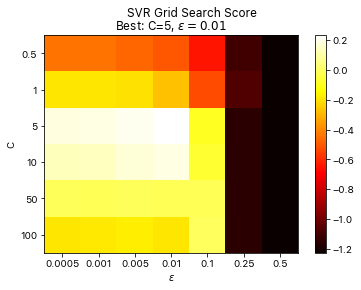

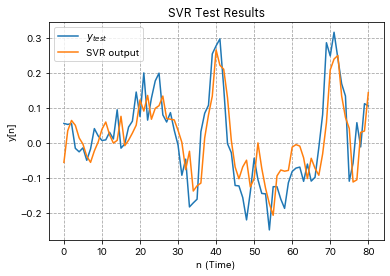

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import svm
from time import time
from sklearn.model_selection import GridSearchCV

# values for grid search
C_values = [.5, 1, 5, 10, 50, 100]
eps_values = [0.0005, 0.001, 0.005, 0.01, 0.1, 0.25, 0.5]
nu_values =[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

# set to True for SVR
# set to False for NuSVR
svr=True

if svr:
	Classifier = svm.SVR
	cname = "SVR"
	param_grid = {'C': C_values,
              'epsilon': eps_values }
else:
	Classifier = svm.NuSVR
	cname = "NuSVR"
	param_grid = {'C': C_values,
              'nu': nu_values }

# read the data file
df = pd.read_csv("data.csv", header=None)

#
# break the data file up into components as numpy arrays
#
#ftest = df.iloc[:,0].to_numpy()
#ftrain = df.iloc[:,1].to_numpy()
Xtest = df.iloc[:,2:21].to_numpy().T
Xtrain = df.iloc[:,21:40].to_numpy().T
ytest = df.iloc[:,40].to_numpy()
ytrain = df.iloc[:,41].to_numpy()

# fit the classifier to training data
clf = GridSearchCV(Classifier(gamma='auto'), param_grid, cv=5)
clf = clf.fit(Xtrain.T, ytrain)

# extract scores and best parameters
scores = clf.cv_results_['mean_test_score'];
C = clf.best_estimator_.get_params()["C"]
if svr:
	scores = scores.reshape(len(C_values),len(eps_values))
	epsilon = clf.best_estimator_.get_params()["epsilon"]
else:
	nu = clf.best_estimator_.get_params()["nu"]
	scores = scores.reshape(len(C_values),len(nu_values))

#plt.figure(figsize=(8, 6))
#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.ylabel('C')

if svr:
	plt.xlabel(r"$\epsilon$")
	plt.title("Best: C=%d, $\epsilon=%.3g$"%(C, epsilon))
else:
	plt.xlabel(r"$\nu$")
	plt.title(r"Best: C=%d, $\nu=%.3g$"%(C, nu))

plt.colorbar()
plt.yticks(np.arange(len(C_values)), C_values)
if svr:
	plt.xticks(np.arange(len(eps_values)), eps_values)
else:
	plt.xticks(np.arange(len(nu_values)), nu_values)

plt.suptitle('{} Grid Search Score'.format(cname))
plt.show()

yhat = clf.predict(Xtest.T)
e = ytest - yhat
e2 = np.dot(e,e)/len(ytest)

trange = list(range(0,len(yhat)))
plt.plot(trange,ytest,label="$y_{test}$")
plt.plot(trange,yhat,label='{} output'.format(cname))
plt.xlabel("n (Time)")
plt.ylabel("y[n]")
plt.grid(True, which='both', color='0.65', linestyle='--')
plt.legend()
plt.title("{} Test Results".format(cname))
# if svr:
# 	plt.title("C=%d, $\epsilon=%.3g, e^2=%.3g$"%(C, epsilon, e2))
# else:
# 	plt.title(r"C=%d, $\nu=%.3g, e^2=%.3g$"%(C, nu, e2))
plt.show()


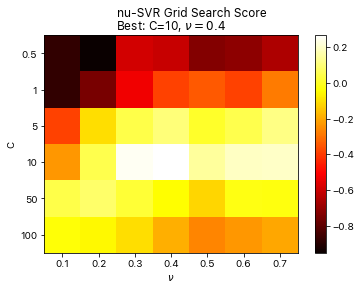

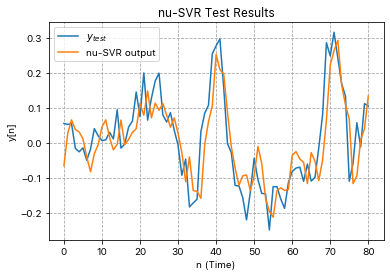

In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import svm
from time import time
from sklearn.model_selection import GridSearchCV

# values for grid search
C_values = [.5, 1, 5, 10, 50, 100]
eps_values = [0.0005, 0.001, 0.005, 0.01, 0.1, 0.25, 0.5]
nu_values =[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

# set to True for SVR
# set to False for NuSVR
svr=False

if svr:
	Classifier = svm.SVR
	cname = "SVR"
	param_grid = {'C': C_values,
              'epsilon': eps_values }
else:
	Classifier = svm.NuSVR
	cname = "nu-SVR"
	param_grid = {'C': C_values,
              'nu': nu_values }

# read the data file
df = pd.read_csv("data.csv", header=None)

#
# break the data file up into components as numpy arrays
#
#ftest = df.iloc[:,0].to_numpy()
#ftrain = df.iloc[:,1].to_numpy()
Xtest = df.iloc[:,2:21].to_numpy().T
Xtrain = df.iloc[:,21:40].to_numpy().T
ytest = df.iloc[:,40].to_numpy()
ytrain = df.iloc[:,41].to_numpy()

# fit the classifier to training data
clf = GridSearchCV(Classifier(gamma='auto'), param_grid, cv=5)
clf = clf.fit(Xtrain.T, ytrain)

# extract scores and best parameters
scores = clf.cv_results_['mean_test_score'];
C = clf.best_estimator_.get_params()["C"]
if svr:
	scores = scores.reshape(len(C_values),len(eps_values))
	epsilon = clf.best_estimator_.get_params()["epsilon"]
else:
	nu = clf.best_estimator_.get_params()["nu"]
	scores = scores.reshape(len(C_values),len(nu_values))

# plt.figure(figsize=(8, 6))
# plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.ylabel('C')

if svr:
	plt.xlabel(r"$\epsilon$")
	plt.title("Best: C=%d, $\epsilon=%.3g$"%(C, epsilon))
else:
	plt.xlabel(r"$\nu$")
	plt.title(r"Best: C=%d, $\nu=%.3g$"%(C, nu))

plt.colorbar()
plt.yticks(np.arange(len(C_values)), C_values)
if svr:
	plt.xticks(np.arange(len(eps_values)), eps_values)
else:
	plt.xticks(np.arange(len(nu_values)), nu_values)

plt.suptitle('{} Grid Search Score'.format(cname))
plt.show()

yhat = clf.predict(Xtest.T)
e = ytest - yhat
e2 = np.dot(e,e)/len(ytest)

trange = list(range(0,len(yhat)))
plt.plot(trange,ytest,label="$y_{test}$")
plt.plot(trange,yhat,label='{} output'.format(cname))
plt.xlabel("n (Time)")
plt.ylabel("y[n]")
plt.grid(True, which='both', color='0.65', linestyle='--')
plt.legend()
plt.title("{} Test Results".format(cname))
# if svr:
# 	plt.title("C=%d, $\epsilon=%.3g, e^2=%.3g$"%(C, epsilon, e2))
# else:
# 	plt.title(r"C=%d, $\nu=%.3g, e^2=%.3g$"%(C, nu, e2))
plt.show()

# from sklearn.metrics import mean_squared_error
# e2=mean_squared_error(yhat, ytest)
# plt.plot(C_values,e2,label="MSE")
# plt.show()
